In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

#### Define propagator

In [2]:
import tdse.propagator.polar
from importlib import reload
reload(tdse.propagator.polar)

<module 'tdse.propagator.polar' from '/home/ahn/Dropbox/py/proj/tdse/tdse/propagator/polar.py'>

In [3]:
import scipy.optimize.nonlin
reload(scipy.optimize.nonlin)

<module 'scipy.optimize.nonlin' from '/home/ahn/py/venv/sci/lib/python3.8/site-packages/scipy/optimize/nonlin.py'>

In [4]:
from tdse.propagator.polar import Propagator_on_Uniform_Grid_Polar_Box_Over_r
prop = Propagator_on_Uniform_Grid_Polar_Box_Over_r(Nr=101, dr=0.2, m_max=0)

#### Prepare initial state of wavefunction

In [5]:
wf_t0 = np.empty(prop.wf_shape, dtype=np.complex)
wf_t0[:] = np.random.rand(*prop.wf_shape)
prop.propagate_to_ground_state(wf_t0)

iteration count at end: 605


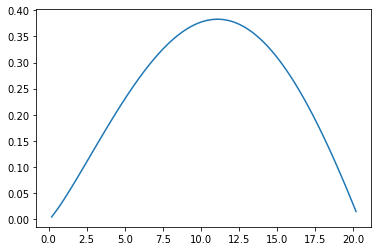

In [7]:
fig, ax = plt.subplots()
for im in range(prop.Nm):
    ax.plot(prop.r_arr, wf_t0[im].real)

#### Prepare initial positions of particles in polar coordinates

In [8]:
qvec_t0_arr = [[2.1, 0.0], [5.6, pi/2.]]
Nq = len(qvec_t0_arr)

#### Configure time array

In [9]:
dt, Nt = 0.05, 101
t_arr = dt * np.arange(Nt)

# Propagate Bohmian particles

In [10]:
def impli_eq(dq, q, dt, Rm_rn, prop):
    """An equation for propagation in implicite Euler method"""
    
    _dq, _q = (np.asarray(_a) for _a in (dq, q))
    _q_next = _q + _dq
    _wf, _dr_wf, _dphi_wf = prop.wf_class.eval_wf_with_wf_deriv_at_q(_q_next, Rm_rn, prop.dr)
    
    _dr, _dphi = _dq
    _eq = np.empty_like(q, dtype=np.float)
    _eq[0] = _dq[0] + dt * prop.hbar/prop.mass * np.imag(_dr_wf/_wf)
    _eq[1] = _dq[1] * _q_next[0]**2 + dt * prop.hbar/prop.mass * np.imag(_dphi_wf/_wf)
    
    return _eq

In [11]:
wf = np.empty_like(wf_t0, dtype=np.complex)
wf[:] = wf_t0

qvec_arr = np.empty_like(qvec_t0_arr)
qvec_arr[:] = qvec_t0_arr

from scipy.optimize import root

for it in range(t_arr.size-1):
    dt = t_arr[it+1] - t_arr[it]
    prop.propagate(wf, dt, Nt=1)
    Rm_rn = prop.wf_class.wf2Rm(wf)
    
    for iq in range(Nq):
        q = qvec_arr[iq]
        r, phi = q
        
        broyden1_opts = {'xtol':1.0, 'uppers':(prop.r_max-r, pi), 'lowers':(-prop.r_max-r, -pi)}
        opts = {'method':'broyden1', 'options':broyden1_opts}
        dq0 = np.zeros_like(q)
        impli_eq_args = (q, dt, Rm_rn, prop)
        sol = root(impli_eq, dq0, args=impli_eq_args, **opts)
        dq = sol.x
        
        qvec_arr[iq] += dq

In [12]:
qvec_t0_arr

[[2.1, 0.0], [5.6, 1.5707963267948966]]

In [13]:
qvec_arr

array([[2.11362661, 0.        ],
       [5.61294405, 1.57079633]])